In [1]:
import numpy as np
import pandas as pd
import lmfit
import datetime
from datetime import date
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import datetime
import argparse
pd.options.mode.chained_assignment = None  # default='warn'
import operator
from matplotlib import pyplot as plt
from matplotlib import pyplot
import warnings

# Understanding of the basic model

Assumption : no vegetation in winter.\
Procedure of the current model
1. Cteate the polynomial model(x=Q, y=VERSCHIL) based on data in winter.
2. Predict VERSCHIL given Q in spring/summer and get a proxy of vegetation by substitution(measured - predicted).
3. Predict vegetation in the next 21 days based on vegetation in the last 7 days using linear model.
4. Calculate the 'risk of vegetation' derived from comparison of vegetation in the past 3 years.
5. Calculate the 'risk factor' derived from precipitation, groundwater level, temperature, cloud, etc. 

Problems of this current model
 1.  Q-V polinomial model\
(statistical aspect)\
-Violation of OLS assumptio of Q-V polinomial model : positive bias of error + heteroskedasticity\
-V affects Q, but in the model Q is set to be dependent variable.\
\
(data aspect)\
-There are many cases where calculated vegetation is negative. The formula to calculate vegetation might be fundamentally wrong.


2.Linear model that predicts the vegetation growth in the next 21 days based on vegetation in the last 7 days.
- From the scatter plot, it does not look linear.
- should include more factors or detailed time series analysis.

In [2]:
# Using combined csv file is not useful since each river has different magnitude of Q, Verschil, thereby, vegetation growth.
# If we combine csv file and plot vegetation growth all together, we can not detect any pattern since each river has different size, therefore, different growth as well.
# Thus, we need to apply model to each csv and find pattern respectively.

In [3]:
# data
data= pd.read_csv("104B_104OYE_feature_table.csv",index_col="TIME",parse_dates=True)
selected_data = data.loc[(data['VERSCHIL']>0) & (data['Q']>0)]

In [4]:
year = 2020
# Winter season where plants are "not" growing from 1st October to end of February
winter_data= selected_data.loc[str(year-1)+'-10-01':str(year)+'-02-28']

# Non-winter season
non_winter_data = selected_data.loc[str(year)+'-03-01':str(year)+'-09-30']

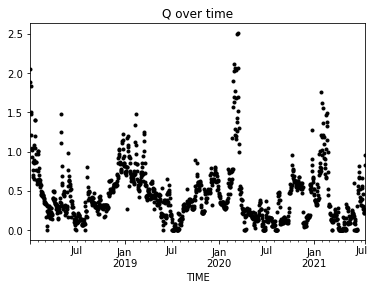

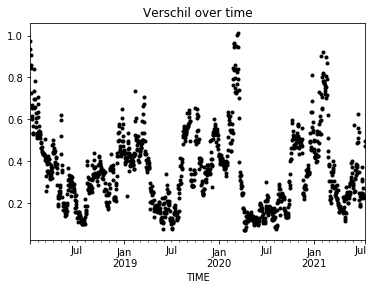

In [5]:
# Time-series plot of Verschil and Q 
warnings.filterwarnings("ignore")

Q = data['Q']
Verschil = data['VERSCHIL']
q_plot = Q.plot(title='Q over time',style='k.')
plt.show()
Verschil.plot(title='Verschil over time',style='k.')
plt.show()

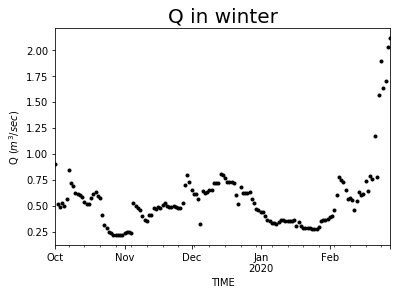

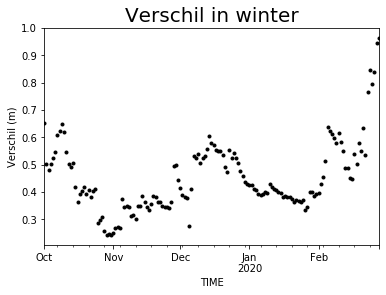

<Figure size 432x288 with 0 Axes>

In [6]:
# Time-series plot of Verschil and Q in winter
warnings.filterwarnings("ignore")

Q_winter = winter_data['Q']
Verschil_winter = winter_data['VERSCHIL']

Q_winter.plot(style='k.')
plt.ylabel('Q ($m^3/sec$)')
plt.title("Q in winter", fontsize = 20)
plt.show()

Verschil_winter.plot(title='Verschil in winter',style='k.')
plt.ylabel("Verschil (m)")
plt.title("Verschil in winter", fontsize = 20)
plt.show()
plt.savefig('Verschil in winter')

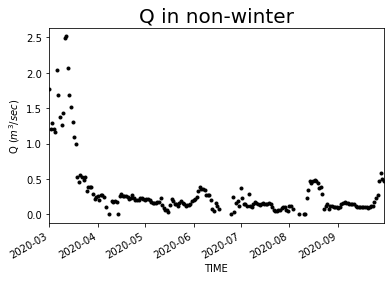

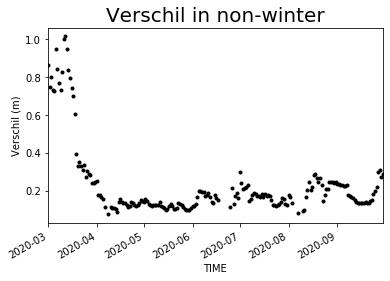

In [7]:
# Time-series plot of Verschil and Q in non-winter
warnings.filterwarnings("ignore")

Q_non_winter = non_winter_data['Q']
Verschil_non_winter = non_winter_data['VERSCHIL']

Q_non_winter.plot(title='Q in non-winter',style='k.')
plt.ylabel('Q ($m^3/sec$)')
plt.title("Q in non-winter", fontsize = 20)
plt.show()

Verschil_non_winter.plot(title='Verschil in non-winter',style='k.')
plt.ylabel("Verschil (m)")
plt.title("Verschil in non-winter", fontsize = 20)
plt.show()

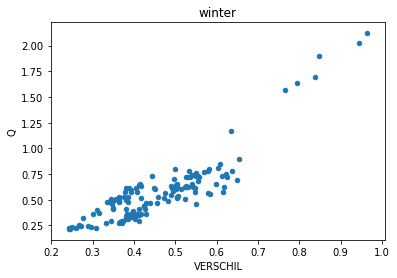

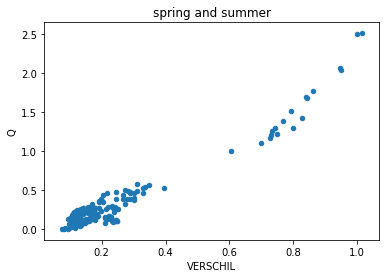

In [8]:
## Relationship between VERSCHIL and Q

# Winter : October ~ Feburary
winter_data.plot.scatter(x='VERSCHIL',y='Q',title='winter')

# non-winter : March ~ September
non_winter_data.plot.scatter(x='VERSCHIL',y='Q',title='spring and summer')


In [9]:
# Make value to zero if it is negative
def negative_to_zero(value):
    return np.clip(value, 0, None)

In [10]:
### Predict vegetation growth from relationship between Q and VERSCHIL

# The polynomial model Aa-en-Maas currently uses
def base_model(winter_data):
    def eqn_poly(x, a, b):
        ''' simple polynomial function'''
        return  a*(x**b)     

    mod = lmfit.Model(eqn_poly)
    lm_result = mod.fit(np.array(winter_data['VERSCHIL']), x=np.array(winter_data['Q']), a=1.0, b=1.0)
    return lm_result

# Calculate vegetation : measured_VERSCHIL - predicted_VERSCHIL
def vegetation(risk_date):
    # Predict vegetation based on the model in specific date
    risk_date_data = selected_data[['VERSCHIL', 'Q']].loc[risk_date]
    model = base_model(winter_data)
    
    pred = model.eval(x=risk_date_data['Q'])

    # If the date is in the winter period, 
    risk_date=datetime.datetime.strptime(risk_date, "%Y-%m-%d")
    if ((risk_date.month <= 2) | (risk_date.month >= 10)):
        # the back water is assumed to be 0 as the plants do "not" grow in winter
        current_vegetation = 0

    else:
        # Calculate the vegetation by plants: Current back water - predicted back water based on winter
        current_vegetation = risk_date_data.loc["VERSCHIL"] - pred
        current_vegetation=negative_to_zero(current_vegetation)
    return current_vegetation

vegetation(risk_date='2021-04-01')

0.0

,VERSCHIL,Q,error
VERSCHIL,0.016660,0.035547,0.022151
Q,0.035547,0.097538,0.061987
error,0.022151,0.061987,0.039847


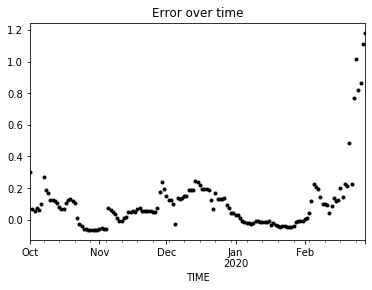

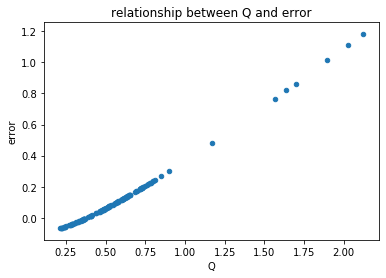

In [11]:
# Problem of Q-V polinomial model : positive bias of error + heteroskedasticity

model = base_model(winter_data)
pred = model.eval(x=winter_data['Q'])
error = winter_data['Q'] - pred
error.mean()
winter_data["error"] = error
error.plot(title='Error over time',style='k.')

# Plot of error on Q
winter_data.plot.scatter(x='Q',y='error',title='relationship between Q and error') # Strong endogeniety

# Covariance : cov(error,Q) > cov(Verschil,Q)
winter_data.cov()

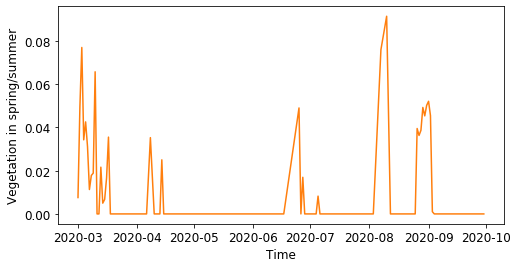

In [15]:
### Visualization of calculated vegetation
# Get the list of every date in csv file
selected_data['TIME'] = selected_data.index
lst_date = selected_data
lst_date['TIME'] = pd.to_datetime(lst_date['TIME'])
lst_date = lst_date['TIME'].dt.date # delete hour/minute information

lst_date = lst_date.astype('str') # convert timestamp to string

# Get the list of the calculated vegetation 
lst_vegetation = []
for i in lst_date:
    lst_vegetation.append(vegetation(i))
    
selected_data['vegetation'] = lst_vegetation
non_winter_data_vegetation = selected_data.loc[str(year)+'-03-01':str(year)+'-09-30']

plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_xlabel('Time')
ax.set_ylabel('Vegetation in spring/summer')

ax.plot(non_winter_data_vegetation.TIME, non_winter_data_vegetation.vegetation, color='tab:orange', label='Vegetation')
# Calculated Vegetation growth by the current model is not increasing over time. It increased a lot suddenly. 